**Задача:** по имеющимся значениям по конкретному веществу предсказать значения ряда (в будущее)

In [112]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 

import itertools

import os
from pathlib import Path

#get my written functions
from userfuncs import prepare_dataframe, find_borders_nan_intervals, count_frequency, count_missing
from userfuncs import get_best_distribution, distribution_by_season, get_metrics

import warnings
warnings.filterwarnings("ignore")

#algorithms
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor

#scaler
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [113]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

In [114]:
from matplotlib import style
style.use('fivethirtyeight')

In [218]:
path_to_data = Path('../../data')
df = pd.read_csv(path_to_data / 'prepared_data_prioksk.csv')
ELEMENTS = df.columns
df.head(2)

,TSP,SO2,PB,CD
0,9.0,0.02,21.0,0.54
1,5.0,0.03,20.0,0.53


In [219]:
IS_NORM = False #is norm mae ans rmse or not

In [220]:
def code_mean(data, cat_feature, real_feature):
    """Simple target encoding"""
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepare_data(df, all_targets, lag_start=1, lag_end=15, test_size=0.2, is_split=True):
    
    start_date = pd.to_datetime('1987-10-01', format='%Y-%m-%d') #дата с которой идет ряд
    #так как данные примерно полные были, то заполним таким индексом для создания фичей дальше
    #полезно в первую очередь в обучающих целях
    df.index = pd.date_range(start=start_date, periods=df.shape[0], freq='D')

    test_index = int(len(df)*(1-test_size))
    df_lag = None
    for col in all_targets:
        ts = df[[col]]
        for i in range(lag_start, lag_end):
            ts[f"{col}_lag_{i}"] = ts[col].shift(i)
        if df_lag is None:
            df_lag = ts
        else:
            df_lag = df_lag.join(ts)
            
    extra_cols = list(set(df.columns) - set(df_lag.columns))
    df_lag = df_lag.join(df[extra_cols])
            
    df_lag["weekday"] = df_lag.index.weekday
    df_lag['is_weekend'] = df_lag.weekday.isin([5,6])*1
    
    for col in all_targets:
        df_lag[f'{col}_weekday_average'] = list(map(code_mean(df_lag[:test_index], 'weekday', col).get, df_lag.weekday))
        
    if 'weekday' in df_lag.columns:
        df_lag = df_lag.drop(["weekday"], axis=1)
    df_lag = df_lag.dropna()
    
    df_lag = df_lag.reset_index(drop=True)
    
    if is_split:
        train = df_lag.loc[:test_index]
        test = df_lag.loc[test_index:]
        return train, test
    else:
        return df_lag

In [221]:
useful_columns = ['is_weekend']
all_targets = list(df.columns)

In [222]:
train, test = prepare_data(df, all_targets, lag_start=1, lag_end=14, test_size=0.2)

### Algorithms

In [223]:
def predict_by_random_forest(X_train, y_train, X_test, **kwargs):
    '''Return predicted values on train and test by Random Forest'''
    
    rf = RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=777, **kwargs
                               #, max_features='sqrt'
                               #, min_samples_split=4
                              )
    rf.fit(X_train, y_train)
    yhat_train = rf.predict(X_train) 
    yhat_test = rf.predict(X_test)
    
    return yhat_train, yhat_test

def predict_by_lin_model(X_train, y_train, X_test, **kwargs):
    '''Return predicted values on train and test by Elastic-Net'''
    
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    #en = ElasticNet(alpha=1, l1_ratio=0.25, random_state=777, **kwargs)
    en = Ridge(random_state=777, alpha=2)
    en.fit(X_train_sc, y_train)
    yhat_train = en.predict(X_train_sc)
    yhat_test = en.predict(X_test_sc)
    
    return yhat_train, yhat_test


def predict_by_lgbm(X_train, y_train, X_test, **kwargs):
    '''Return predicted values on train and test by lgbm'''
    
    params = {
        'n_estimators': 1000
        , 'learning_rate': 0.05
        , 'max_leaves': 31
        , 'max_depth': -1
        , 'subsample': 0.85
        , 'colsample_bytree': 0.8
        , 'reg_alpha': 1e-2
        , 'reg_lambda': 1
        , 'min_spit_gain': 1e-3
        
        , 'n_jobs': -1
        , 'random_state': 777
    }
    
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_metric=['mse'], verbose=False,
             eval_set=[(X_test, y_test)], early_stopping_rounds=100)
    
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)
    
    return pred_train, pred_test

In [224]:
def plot_prediction(y_test, pred_test, target_name, y_train=None, pred_train=None):
    fontsize = 13
    lw = 1.5
    if y_train is not None and pred_train is not None:
        #train and test plot
        plt.figure(figsize=(10, 5))
        plt.title(f"{target_name} prediction", fontsize=fontsize)
        plt.plot(np.hstack([y_train.values, y_test.values]), lw=lw, label='actual')
        plt.plot(range(len(y_train)), pred_train, c='red', lw=lw, label='prediction')
        plt.plot(range(len(y_train), len(y_train) + len(y_test)), pred_test, lw=lw, c='red', label='prediction')
        plt.vlines(len(y_train), min(y_train), max(max(y_train), max(y_test))
           , ls='--', label='left train / right test')
#        plt.xlabel('Observation')
#        plt.ylabel('Quantity')
        plt.legend(loc='best', fontsize=fontsize)
        plt.grid(True)
    else:
        #test plot      
        plt.figure(figsize=(10, 5))
        plt.title(f"{target_name} prediction", fontsize=fontsize)
        lw=2
        plt.plot(y_test.values, label='actual', lw=lw)
        plt.plot(pred_test, c='red', label='prediction', lw=lw)
        #plt.xlabel('Observation')
        #plt.ylabel('Quantity')
        plt.legend(fontsize=fontsize)
        plt.grid(True)

### TSP

In [225]:
target_name = 'TSP'
X_train, X_test = train.drop([target_name], axis=1), test.drop([target_name], axis=1)
y_train, y_test = train[target_name], test[target_name]

In [226]:
#to take lag features
target_cols = [name for name in train.columns if name.startswith(target_name)]
#take lag features and some other
train_columns = target_cols + all_targets + useful_columns
useless_cols = ([target_name]
#+ ['TSP_weekday_average', 'is_weekend']
               )
train_columns = list(set(train_columns) - set(useless_cols))

In [227]:
pred_train_rf, pred_test_rf = predict_by_random_forest(X_train=X_train, y_train=y_train, X_test=X_test)
pred_train_en, pred_test_en = predict_by_lin_model(X_train=X_train, y_train=y_train, X_test=X_test)
pred_train_lgb, pred_test_lgb = predict_by_lgbm(X_train=X_train, y_train=y_train, X_test=X_test)

In [228]:
all_predictions = {'Random Forest': {'train': pred_train_rf, 'test': pred_test_rf}
                   , 'Linear model': {'train': pred_train_en, 'test': pred_test_en}
                   , 'Lightgbm': {'train': pred_train_lgb, 'test': pred_test_lgb}
                  }

In [231]:
print('\t\t\t\t\t', target_name.upper())
for method, preds in all_predictions.items():
    print(method)
    print('\t\t\t  TRAIN')
    for k, v in get_metrics(y_train, preds['train'], metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
        print(f"{k}: {v:<20}", end='\t')
    print()
    print('\t\t\t  TEST')
    for k, v in get_metrics(y_test, preds['test'], metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
        print(f"{k}: {v:<20}", end='\t')

    print('\n\n')

					 TSP
Random Forest
			  TRAIN
RMSE: 8.303624591782667   	MAE: 5.105820618153364   	
			  TEST
RMSE: 16.94796212214461   	MAE: 12.379226384364822  	


Linear model
			  TRAIN
RMSE: 20.806684793261404  	MAE: 12.920009247098433  	
			  TEST
RMSE: 16.95340726319435   	MAE: 11.904814416870739  	


Lightgbm
			  TRAIN
RMSE: 15.95282734245486   	MAE: 9.349479146430683   	
			  TEST
RMSE: 16.67222169206408   	MAE: 12.14555589440985   	




In [239]:
#для отрисовки лучшего алгоритма
pred_train = pred_train_en
pred_test = pred_test_en

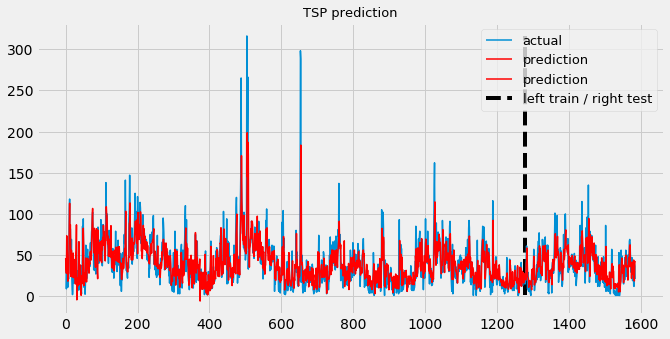

In [240]:
#train
plot_prediction(y_test=y_test, pred_test=pred_test, target_name=target_name, y_train=y_train, pred_train=pred_train)

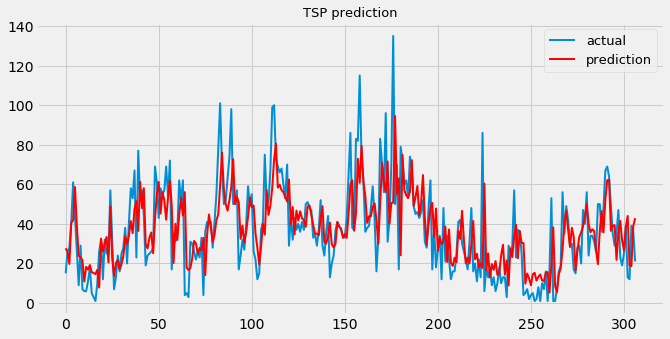

In [241]:
#test
plot_prediction(y_test=y_test, pred_test=pred_test, target_name=target_name)

### SO2

In [242]:
target_name = 'SO2'
X_train, X_test = train.drop([target_name], axis=1), test.drop([target_name], axis=1)
y_train, y_test = train[target_name], test[target_name]

In [243]:
#to take lag features
target_cols = [name for name in train.columns if name.startswith(target_name)]
#take lag features and some other
train_columns = target_cols + all_targets + useful_columns
useless_cols = ([target_name]
#+ ['TSP_weekday_average', 'is_weekend']
               )
train_columns = list(set(train_columns) - set(useless_cols))

In [244]:
pred_train_rf, pred_test_rf = predict_by_random_forest(X_train=X_train, y_train=y_train, X_test=X_test)
pred_train_en, pred_test_en = predict_by_elastic_net(X_train=X_train, y_train=y_train, X_test=X_test)
pred_train_lgb, pred_test_lgb = predict_by_lgbm(X_train=X_train, y_train=y_train, X_test=X_test)

In [245]:
all_predictions = {'Random Forest': {'train': pred_train_rf, 'test': pred_test_rf}
                   , 'Elastic Net': {'train': pred_train_en, 'test': pred_test_en}
                   , 'Lightgbm': {'train': pred_train_lgb, 'test': pred_test_lgb}
                  }

In [246]:
print('\t\t\t\t\t', target_name.upper())
for method, preds in all_predictions.items():
    print(method)
    print('\t\t\t  TRAIN')
    for k, v in get_metrics(y_train, preds['train'], metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
        print(f"{k}: {v:<20}", end='\t')
    print()
    print('\t\t\t  TEST')
    for k, v in get_metrics(y_test, preds['test'], metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
        print(f"{k}: {v:<20}", end='\t')

    print('\n\n')

					 SO2
Random Forest
			  TRAIN
RMSE: 1.1319240529286068  	MAE: 0.6301870207355234  	
			  TEST
RMSE: 1.9394162954018972  	MAE: 1.1365828583061894  	


Elastic Net
			  TRAIN
RMSE: 2.8459035806918758  	MAE: 1.7262339343922535  	
			  TEST
RMSE: 1.989517739276342   	MAE: 1.2776920485825933  	


Lightgbm
			  TRAIN
RMSE: 1.9182340829772186  	MAE: 1.0477682634597543  	
			  TEST
RMSE: 1.9496825314571882  	MAE: 1.184956962705938   	




In [247]:
#для отрисовки лучшего алгоритма
pred_train = pred_train_rf
pred_test = pred_test_rf

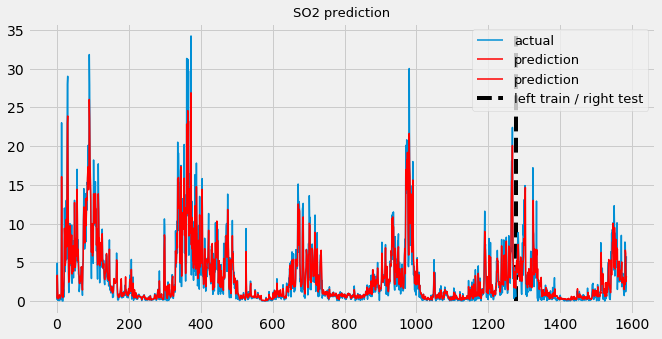

In [248]:
#train
plot_prediction(y_test=y_test, pred_test=pred_test, target_name=target_name, y_train=y_train, pred_train=pred_train)

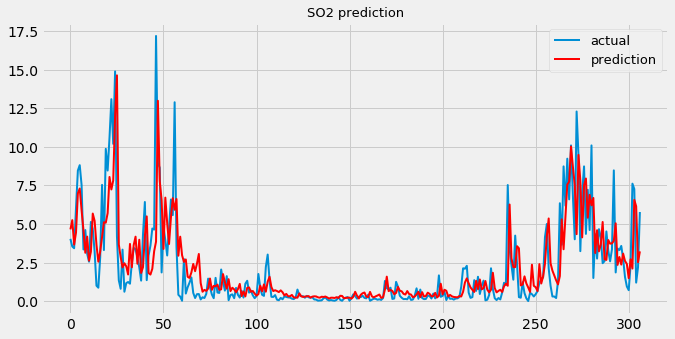

In [249]:
#test
plot_prediction(y_test=y_test, pred_test=pred_test, target_name=target_name)

### PB

In [250]:
target_name = 'PB'
X_train, X_test = train.drop([target_name], axis=1), test.drop([target_name], axis=1)
y_train, y_test = train[target_name], test[target_name]

In [251]:
#to take lag features
target_cols = [name for name in train.columns if name.startswith(target_name)]
#take lag features and some other
train_columns = target_cols + all_targets + useful_columns
useless_cols = ([target_name]
#+ ['TSP_weekday_average', 'is_weekend']
               )
train_columns = list(set(train_columns) - set(useless_cols))

In [252]:
pred_train_rf, pred_test_rf = predict_by_random_forest(X_train=X_train, y_train=y_train, X_test=X_test)
pred_train_en, pred_test_en = predict_by_elastic_net(X_train=X_train, y_train=y_train, X_test=X_test)
pred_train_lgb, pred_test_lgb = predict_by_lgbm(X_train=X_train, y_train=y_train, X_test=X_test)

In [253]:
all_predictions = {'Random Forest': {'train': pred_train_rf, 'test': pred_test_rf}
                   , 'Elastic Net': {'train': pred_train_en, 'test': pred_test_en}
                   , 'Lightgbm': {'train': pred_train_lgb, 'test': pred_test_lgb}
                  }

In [254]:
print('\t\t\t\t\t', target_name.upper())
for method, preds in all_predictions.items():
    print(method)
    print('\t\t\t  TRAIN')
    for k, v in get_metrics(y_train, preds['train'], metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
        print(f"{k}: {v:<20}", end='\t')
    print()
    print('\t\t\t  TEST')
    for k, v in get_metrics(y_test, preds['test'], metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
        print(f"{k}: {v:<20}", end='\t')

    print('\n\n')

					 PB
Random Forest
			  TRAIN
RMSE: 2.1467870175838124  	MAE: 1.4146359154929584  	
			  TEST
RMSE: 3.3527975120307456  	MAE: 2.485016205211727   	


Elastic Net
			  TRAIN
RMSE: 5.4741036568677615  	MAE: 3.699632963902753   	
			  TEST
RMSE: 3.345968304603777   	MAE: 2.4085061023986136  	


Lightgbm
			  TRAIN
RMSE: 4.213112020672756   	MAE: 2.8160010277786554  	
			  TEST
RMSE: 3.378291844810058   	MAE: 2.5563228767203054  	




In [255]:
#для отрисовки лучшего алгоритма
pred_train = pred_train_en
pred_test = pred_test_en

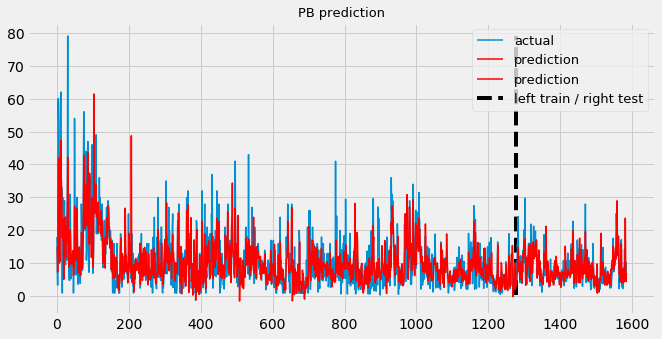

In [256]:
#train
plot_prediction(y_test=y_test, pred_test=pred_test, target_name=target_name, y_train=y_train, pred_train=pred_train)

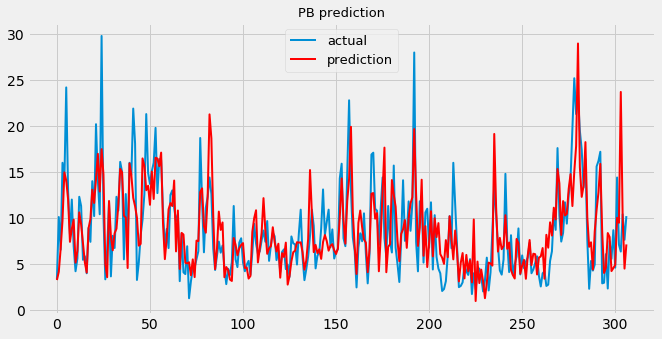

In [257]:
#test
plot_prediction(y_test=y_test, pred_test=pred_test, target_name=target_name)

### CD

In [258]:
target_name = 'CD'
X_train, X_test = train.drop([target_name], axis=1), test.drop([target_name], axis=1)
y_train, y_test = train[target_name], test[target_name]

In [259]:
#to take lag features
target_cols = [name for name in train.columns if name.startswith(target_name)]
#take lag features and some other
train_columns = target_cols + all_targets + useful_columns
useless_cols = ([target_name]
#+ ['TSP_weekday_average', 'is_weekend']
               )
train_columns = list(set(train_columns) - set(useless_cols))

In [260]:
X_train, X_test = X_train[train_columns], X_test[train_columns]

In [261]:
pred_train_rf, pred_test_rf = predict_by_random_forest(X_train=X_train, y_train=y_train, X_test=X_test)
pred_train_en, pred_test_en = predict_by_elastic_net(X_train=X_train, y_train=y_train, X_test=X_test)
pred_train_lgb, pred_test_lgb = predict_by_lgbm(X_train=X_train, y_train=y_train, X_test=X_test)

In [262]:
all_predictions = {'Random Forest': {'train': pred_train_rf, 'test': pred_test_rf}
                   , 'Elastic Net': {'train': pred_train_en, 'test': pred_test_en}
                   , 'Lightgbm': {'train': pred_train_lgb, 'test': pred_test_lgb}
                  }

In [263]:
print('\t\t\t\t\t', target_name.upper())
for method, preds in all_predictions.items():
    print(method)
    print('\t\t\t  TRAIN')
    for k, v in get_metrics(y_train, preds['train'], metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
        print(f"{k}: {v:<20}", end='\t')
    print()
    print('\t\t\t  TEST')
    for k, v in get_metrics(y_test, preds['test'], metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
        print(f"{k}: {v:<20}", end='\t')

    print('\n\n')

					 CD
Random Forest
			  TRAIN
RMSE: 0.07564436005569468 	MAE: 0.043427014866979835	
			  TEST
RMSE: 0.13516801462749517 	MAE: 0.08725114006514653 	


Elastic Net
			  TRAIN
RMSE: 0.19178502681843748 	MAE: 0.10938394791930345 	
			  TEST
RMSE: 0.12492884029484623 	MAE: 0.08015950481984777 	


Lightgbm
			  TRAIN
RMSE: 0.14711863420228713 	MAE: 0.08036673768471364 	
			  TEST
RMSE: 0.1353531573185883  	MAE: 0.087304238272244   	




In [267]:
#для отрисовки лучшего алгоритма
pred_train = pred_train_lgb
pred_test = pred_test_lgb

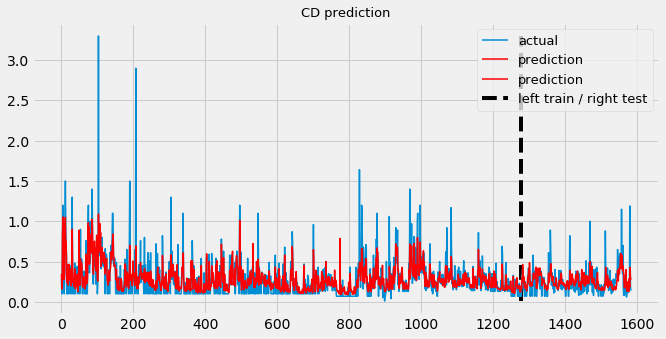

In [265]:
#train
plot_prediction(y_test=y_test, pred_test=pred_test, target_name=target_name, y_train=y_train, pred_train=pred_train)

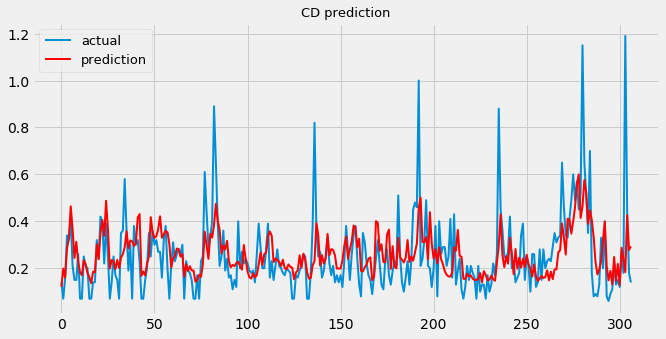

In [266]:
#test
plot_prediction(y_test=y_test, pred_test=pred_test, target_name=target_name)